### Imports

In [1]:
# Import necessary libraries for data manipulation and visualization
import pandas as pd
import polars as pl
import numpy as np

from datetime import datetime

from hmmlearn.hmm import GaussianHMM
from pandas_datareader.data import DataReader

import matplotlib.pyplot as plt

# Verify all libraries are imported correctly
print("Libraries imported successfully")

Libraries imported successfully


### Structure Data

In [2]:
# Import necessary libraries
import yfinance as yf

# Set start and end dates for the data extraction
start_date = "2017-01-01"
end_date = "2024-07-01"
symbol = "SPY"

# Fetch data using yfinance
data = yf.download(symbol, start=start_date, end=end_date)
data.head(3)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,225.039993,225.830002,223.880005,225.240005,198.560059,91366500
2017-01-04,225.619995,226.750000,225.610001,226.580002,199.741318,78744400
2017-01-05,226.270004,226.580002,225.479996,226.399994,199.582642,78379000


In [3]:
# Convert to Polars DataFrame and include dates
import polars as pl

data.reset_index(inplace=True) # need to add the date as index otherwise it will drop the date during conversion
data = pl.DataFrame(data)

# Select relevant columns: Date, Open, High, Low, Adj Close
data = data.select(["Date", "Open", "High", "Low", "Adj Close"]) # date is not default added in polars

In [4]:

print(data.columns)
print(data.schema)

['Date', 'Open', 'High', 'Low', 'Adj Close']
OrderedDict({'Date': Datetime(time_unit='ns', time_zone=None), 'Open': Float64, 'High': Float64, 'Low': Float64, 'Adj Close': Float64})


In [5]:
data.head(3)

Date,Open,High,Low,Adj Close
datetime[ns],f64,f64,f64,f64
2017-01-03 00:00:00,225.039993,225.830002,223.880005,198.560059
2017-01-04 00:00:00,225.619995,226.75,225.610001,199.741318
2017-01-05 00:00:00,226.270004,226.580002,225.479996,199.582642


In [6]:
# Create a copy of the dataframe and add returns and range columns
df = data.clone()

# Calculate daily returns
df = df.with_columns((pl.col("Adj Close") / pl.col("Adj Close").shift(1) - 1).alias("Returns")) # the -1 returns the percent return in decimals

# Calculate daily range (volatility)
df = df.with_columns((pl.col("High") / pl.col("Low")-1).alias("Range")) # the -1 returns the percent return in decimals

# Drop NaN values created by the pct_change method
# In Polars, the drop_nulls method does not require the inplace=True parameter as it returns a new DataFrame by default. 
df = df.drop_nulls()

# Display the updated dataframe with new columns
print("Length of Dataframe: ", len(df))
df.head()

Length of Dataframe:  1883


Date,Open,High,Low,Adj Close,Returns,Range
datetime[ns],f64,f64,f64,f64,f64,f64
2017-01-04 00:00:00,225.619995,226.75,225.610001,199.741318,0.005949,0.005053
2017-01-05 00:00:00,226.270004,226.580002,225.479996,199.582642,-0.000794,0.004879
2017-01-06 00:00:00,226.529999,227.75,225.899994,200.296692,0.003578,0.008189
2017-01-09 00:00:00,226.910004,227.070007,226.419998,199.635574,-0.003301,0.002871
2017-01-10 00:00:00,226.479996,227.449997,226.009995,199.635574,0.0,0.006371


In [7]:
df.tail()

Date,Open,High,Low,Adj Close,Returns,Range
datetime[ns],f64,f64,f64,f64,f64,f64
2024-06-24 00:00:00,544.330017,546.950012,542.619995,542.73999,-0.003251,0.00798
2024-06-25 00:00:00,543.98999,545.200012,542.440002,544.830017,0.003851,0.005088
2024-06-26 00:00:00,543.690002,546.23999,543.030029,545.51001,0.001248,0.005911
2024-06-27 00:00:00,545.369995,546.960022,544.609985,546.369995,0.001576,0.004315
2024-06-28 00:00:00,547.159973,550.280029,542.950012,544.219971,-0.003935,0.0135


In [8]:
# Calculate moving averages
df = df.with_columns([
    pl.col('Adj Close').rolling_mean(window_size=12).alias('MA12'),
    pl.col('Adj Close').rolling_mean(window_size=21).alias('MA21')
])
df.head(2)


Date,Open,High,Low,Adj Close,Returns,Range,MA12,MA21
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64
2017-01-04 00:00:00,225.619995,226.75,225.610001,199.741318,0.005949,0.005053,null,null
2017-01-05 00:00:00,226.270004,226.580002,225.479996,199.582642,-0.000794,0.004879,null,null


In [9]:
df.tail(2)

Date,Open,High,Low,Adj Close,Returns,Range,MA12,MA21
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64
2024-06-27 00:00:00,545.369995,546.960022,544.609985,546.369995,0.001576,0.004315,543.15421,536.84654
2024-06-28 00:00:00,547.159973,550.280029,542.950012,544.219971,-0.003935,0.0135,543.903931,537.789958


In [10]:
# Structure Data
X_train = df.select(['Date','Returns', 'Range'])[:500] # in polars we use .select and we don't use iloc
# remember to add date since in polars index is not defualt

In [11]:
X_train.head(3)

Date,Returns,Range
datetime[ns],f64,f64
2017-01-04 00:00:00,0.005949,0.005053
2017-01-05 00:00:00,-0.000794,0.004879
2017-01-06 00:00:00,0.003578,0.008189


In [12]:
X_test = df.select(['Date','Returns', 'Range'])[500:]
save_df = df[500:]
# also can use
# X_train = df.select(['Returns', 'Range']).slice(0, 500)
# X_test = df.select(['Returns', 'Range']).slice(500)
# save_df = df.slice(500)


print("Train Length: ", len(X_train))
print("Test Length: ", len(X_test))

# Print the first row's date

print("\nX_train From: ", X_train['Date'][1])
print("X_train To: ", X_train['Date'][-1])
print("\nX_test From: ", X_test['Date'][1])
print("X_test To: ", X_test['Date'][-1])

Train Length:  500
Test Length:  1383

X_train From:  2017-01-05 00:00:00
X_train To:  2018-12-28 00:00:00

X_test From:  2019-01-02 00:00:00
X_test To:  2024-06-28 00:00:00


## Train HMM

In [13]:
#Data Preparation
import polars as pl
import numpy as np
from hmmlearn.hmm import GaussianHMM

# Convert Polars DataFrame to NumPy array
X_train_np = X_train.to_numpy()
print("Shape of X_train_np:", X_train_np.shape)

# Display first few rows of the data
print("\nFirst few rows of X_train_np:")
print(X_train_np[:5])

# Determine the number of features
n_features = X_train_np.shape[1]
print(f"\nNumber of features detected: {n_features}")

Shape of X_train_np: (500, 3)

First few rows of X_train_np:
[[ 1.48348800e+18  5.94912775e-03  5.05296479e-03]
 [ 1.48357440e+18 -7.94408234e-04  4.87850862e-03]
 [ 1.48366080e+18  3.57771742e-03  8.18949160e-03]
 [ 1.48392000e+18 -3.30069133e-03  2.87081159e-03]
 [ 1.48400640e+18  0.00000000e+00  6.37141045e-03]]

Number of features detected: 3


In [14]:
hmm_model = GaussianHMM(n_components=4, covariance_type="full", n_iter=100).fit(X_train)
print("Model Score:", hmm_model.score(X_train))

Model Score: -15391.054630881827


In [15]:
# Check Results
hidden_states = hmm_model.predict(X_train)
print("First 20 hidden states:", hidden_states[:20])
print("\nUnique states:", np.unique(hidden_states))
print("\nState frequencies:")
for i in range(hmm_model.n_components):
    print(f"State {i}: {np.sum(hidden_states == i) / len(hidden_states):.2%}")

First 20 hidden states: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Unique states: [0 1 2 3]

State frequencies:
State 0: 52.00%
State 1: 1.80%
State 2: 13.60%
State 3: 32.60%


In [16]:
#Make Predictions on Test Data

# Clone the DataFrame and drop specified columns
df_main = save_df.clone()
df_main = df_main.drop(["High", "Low"])

# Predict using HMM model
hmm_results = hmm_model.predict(X_test)

# Convert hmm_results to a Polars Series
hmm_series = pl.Series('HMM', hmm_results)

# Add the HMM results to the DataFrame
df_main = df_main.with_columns(hmm_series)

# Display the first row
print(df_main.head(1))

shape: (1, 8)
┌──────────────┬────────────┬────────────┬──────────┬──────────┬────────────┬────────────┬─────┐
│ Date         ┆ Open       ┆ Adj Close  ┆ Returns  ┆ Range    ┆ MA12       ┆ MA21       ┆ HMM │
│ ---          ┆ ---        ┆ ---        ┆ ---      ┆ ---      ┆ ---        ┆ ---        ┆ --- │
│ datetime[ns] ┆ f64        ┆ f64        ┆ f64      ┆ f64      ┆ f64        ┆ f64        ┆ i64 │
╞══════════════╪════════════╪════════════╪══════════╪══════════╪════════════╪════════════╪═════╡
│ 2018-12-31   ┆ 249.559998 ┆ 228.866135 ┆ 0.008759 ┆ 0.010991 ┆ 228.386855 ┆ 235.695214 ┆ 0   │
│ 00:00:00     ┆            ┆            ┆          ┆          ┆            ┆            ┆     │
└──────────────┴────────────┴────────────┴──────────┴──────────┴────────────┴────────────┴─────┘


In [17]:
df_main.head()

Date,Open,Adj Close,Returns,Range,MA12,MA21,HMM
datetime[ns],f64,f64,f64,f64,f64,f64,i64
2018-12-31 00:00:00,249.559998,228.866135,0.008759,0.010991,228.386855,235.695214,0
2019-01-02 00:00:00,245.979996,229.104233,0.00104,0.021387,227.34524,234.726721,3
2019-01-03 00:00:00,248.229996,223.637115,-0.023863,0.020109,226.21979,233.425484,3
2019-01-04 00:00:00,247.589996,231.128021,0.033496,0.024032,226.106277,232.322716,3
2019-01-07 00:00:00,252.690002,232.950409,0.007885,0.016926,226.165873,231.699086,3


## Run Backtest

#### Add Signals MA and Combined

In [18]:
# Calculate MA Signals
df_main = df_main.with_columns(
    pl.when(pl.col("MA12") > pl.col("MA21")).then(1).otherwise(0).alias("MA_Signal")
)
df_main.head()

Date,Open,Adj Close,Returns,Range,MA12,MA21,HMM,MA_Signal
datetime[ns],f64,f64,f64,f64,f64,f64,i64,i32
2018-12-31 00:00:00,249.559998,228.866135,0.008759,0.010991,228.386855,235.695214,0,0
2019-01-02 00:00:00,245.979996,229.104233,0.00104,0.021387,227.34524,234.726721,3,0
2019-01-03 00:00:00,248.229996,223.637115,-0.023863,0.020109,226.21979,233.425484,3,0
2019-01-04 00:00:00,247.589996,231.128021,0.033496,0.024032,226.106277,232.322716,3,0
2019-01-07 00:00:00,252.690002,232.950409,0.007885,0.016926,226.165873,231.699086,3,0


In [19]:
df_main.columns
df_main.head()

Date,Open,Adj Close,Returns,Range,MA12,MA21,HMM,MA_Signal
datetime[ns],f64,f64,f64,f64,f64,f64,i64,i32
2018-12-31 00:00:00,249.559998,228.866135,0.008759,0.010991,228.386855,235.695214,0,0
2019-01-02 00:00:00,245.979996,229.104233,0.00104,0.021387,227.34524,234.726721,3,0
2019-01-03 00:00:00,248.229996,223.637115,-0.023863,0.020109,226.21979,233.425484,3,0
2019-01-04 00:00:00,247.589996,231.128021,0.033496,0.024032,226.106277,232.322716,3,0
2019-01-07 00:00:00,252.690002,232.950409,0.007885,0.016926,226.165873,231.699086,3,0


In [20]:
df_main.columns

['Date',
 'Open',
 'Adj Close',
 'Returns',
 'Range',
 'MA12',
 'MA21',
 'HMM',
 'MA_Signal']

In [21]:
# HMM Signals
favourable_states = [0,3] # we removed 1,2,3 states. Will give a signal when in 0 state

# Add HMM_Signal column to df_main
# This sets all states to 1 (favorable) to start
df_main = df_main.with_columns(
    pl.when(pl.col("HMM").is_in(favourable_states))
    .then(1)
    .otherwise(0)
    .alias("HMM_Signal")
)

df_main.head()

# The next step (not shown here) would involve analyzing the performance
# of each state and removing states that result in losses from the
# favourable_states list. This process helps refine our strategy by
# identifying which HMM states are truly profitable.

Date,Open,Adj Close,Returns,Range,MA12,MA21,HMM,MA_Signal,HMM_Signal
datetime[ns],f64,f64,f64,f64,f64,f64,i64,i32,i32
2018-12-31 00:00:00,249.559998,228.866135,0.008759,0.010991,228.386855,235.695214,0,0,1
2019-01-02 00:00:00,245.979996,229.104233,0.00104,0.021387,227.34524,234.726721,3,0,1
2019-01-03 00:00:00,248.229996,223.637115,-0.023863,0.020109,226.21979,233.425484,3,0,1
2019-01-04 00:00:00,247.589996,231.128021,0.033496,0.024032,226.106277,232.322716,3,0,1
2019-01-07 00:00:00,252.690002,232.950409,0.007885,0.016926,226.165873,231.699086,3,0,1


In [22]:
# Add Combined Signal
# For trading purposes, we're creating a combined signal based on both MA and HMM signals

# Initialize the Main_Signal column with 0 (no trade signal)
df_main = df_main.with_columns(pl.lit(0).alias("Main_Signal"))

# Create a combined signal:
# If MA_Signal is 1 (bullish) and HMM_Signal is 1 (favorable state), set Main_Signal to 1 (buy/long signal)
df_main = df_main.with_columns(
    pl.when((pl.col("MA_Signal") == 1) & (pl.col("HMM_Signal") == 1))
    .then(1)
    .otherwise(pl.col("Main_Signal"))
    .alias("Main_Signal")
)

# Shift the Main_Signal by 1 day
# This is done to avoid look-ahead bias, ensuring we're using yesterday's signal for today's trade
df_main = df_main.with_columns(
    pl.col("Main_Signal").shift(1).alias("Main_Signal")
)

# Note: The first row will have a null value for Main_Signal due to the shift
# You might want to handle this null value depending on your trading strategy


In [23]:
df_main.head(3)

Date,Open,Adj Close,Returns,Range,MA12,MA21,HMM,MA_Signal,HMM_Signal,Main_Signal
datetime[ns],f64,f64,f64,f64,f64,f64,i64,i32,i32,i32
2018-12-31 00:00:00,249.559998,228.866135,0.008759,0.010991,228.386855,235.695214,0,0,1,null
2019-01-02 00:00:00,245.979996,229.104233,0.00104,0.021387,227.34524,234.726721,3,0,1,0
2019-01-03 00:00:00,248.229996,223.637115,-0.023863,0.020109,226.21979,233.425484,3,0,1,0


### Add Returns Benchmark and Strategy

In [24]:
# Benchmark Returns 
import polars as pl

# Step 1: Calculate log returns
# Log returns are used because they are time additive. This means that the log return over multiple periods
# is the sum of the log returns of each individual period. This is useful for performance analysis and risk management.
df_main = df_main.with_columns([
    (pl.col('Adj Close') / pl.col('Adj Close').shift(1)).log().alias('lrets_bench')
])

# Step 2: Calculate cumulative returns
# Cumulative returns help in understanding the total return of an asset over a period of time. It helps traders to see 
# the compounded effect of returns over time, which is crucial for long-term investment strategies.
df_main = df_main.with_columns([
    pl.col('lrets_bench').cumsum().alias('bench_prod')
])

# Step 3: Calculate normalized log returns with exponent
# Exponentiating the cumulative log returns gives us the actual cumulative returns in percentage form.
# This is useful for traders as it converts the log returns back into a more interpretable form of normal returns.
df_main = df_main.with_columns([
    (pl.col('bench_prod').exp() - 1).alias('bench_prod_exp')
])



/var/folders/4w/6x3yk1r13xvcwchd72ftlnsc0000gn/T/ipykernel_28480/1078449500.py:15: DeprecationWarning: `cumsum` is deprecated. It has been renamed to `cum_sum`.
  pl.col('lrets_bench').cumsum().alias('bench_prod')


In [25]:
df_main.columns


['Date',
 'Open',
 'Adj Close',
 'Returns',
 'Range',
 'MA12',
 'MA21',
 'HMM',
 'MA_Signal',
 'HMM_Signal',
 'Main_Signal',
 'lrets_bench',
 'bench_prod',
 'bench_prod_exp']

In [26]:
#Add Strategy Returns

import polars as pl

# Step 1: Calculate log returns for strategy using Open prices to avoid look-ahead bias
# Using Open prices ensures that we do not use future information when calculating returns.
# This helps in getting the worst execution price and making the backtest results more realistic.
# Multiplying by Main_Signal ensures that the returns are conditional on the trading signals generated by the strategy.
df_main = df_main.with_columns([
    ((pl.col('Open').shift(-1) / pl.col('Open')).log() * pl.col('Main_Signal')).alias('lrets_strat')
])

# Step 2: Calculate cumulative strategy returns
# Cumulative returns help in understanding the overall performance of the strategy over the entire period.
# It gives a continuous view of how the strategy performs over time.
df_main = df_main.with_columns([
    pl.col('lrets_strat').cumsum().alias('lrets_prod')
])

# Step 3: Calculate normalized strategy returns with exponent
# Exponentiating the cumulative log returns converts them back into a more interpretable form of normal returns.
# This helps traders see the actual return on investment over the period.
df_main = df_main.with_columns([
    (pl.col('lrets_prod').exp() - 1).alias('strat_prod_exp')
])



/var/folders/4w/6x3yk1r13xvcwchd72ftlnsc0000gn/T/ipykernel_28480/3750535998.py:17: DeprecationWarning: `cumsum` is deprecated. It has been renamed to `cum_sum`.
  pl.col('lrets_strat').cumsum().alias('lrets_prod')


In [27]:
# Review Results Table
# Drop rows with any NaN values
df_main = df_main.drop_nulls()

In [28]:
df_main.tail(3)

Date,Open,Adj Close,Returns,Range,MA12,MA21,HMM,MA_Signal,HMM_Signal,Main_Signal,lrets_bench,bench_prod,bench_prod_exp,lrets_strat,lrets_prod,strat_prod_exp
datetime[ns],f64,f64,f64,f64,f64,f64,i64,i32,i32,i32,f64,f64,f64,f64,f64,f64
2024-06-25 00:00:00,543.98999,544.830017,0.003851,0.005088,541.016729,535.130528,3,1,1,1,0.003843,0.867337,1.380562,-0.000552,0.261985,0.299507
2024-06-26 00:00:00,543.690002,545.51001,0.001248,0.005911,542.118164,535.976839,3,1,1,1,0.001247,0.868584,1.383533,0.003085,0.26507,0.303522
2024-06-27 00:00:00,545.369995,546.369995,0.001576,0.004315,543.15421,536.84654,3,1,1,1,0.001575,0.870159,1.387291,0.003277,0.268347,0.3078


## Calculate Metrics

In [29]:
import polars as pl

def sharpe_ratio(df, returns_col, trading_days=255, risk_free_rate=0.01):
    """
    Calculate the Sharpe Ratio for a given series of returns in a Polars DataFrame.
    :param df: Polars DataFrame containing the returns column
    :param returns_col: Name of the returns column in the DataFrame
    :param trading_days: Number of trading days in a year (255 for stocks, 365 for crypto)
    :param risk_free_rate: Risk-free rate, default is 0.01 (1%)
    :return: Sharpe Ratio rounded to two decimal places
    """
    N = trading_days
    NSQRT = N ** 0.5  # Square root of the number of trading days
    
    # Calculate mean return and annualize it
    mean_return = df.select(pl.col(returns_col).mean())[0, 0] * N
    
    # Calculate standard deviation and annualize it
    std_dev = df.select(pl.col(returns_col).std())[0, 0] * NSQRT
    
    # Calculate Sharpe Ratio
    sharpe_ratio = round((mean_return - risk_free_rate) / std_dev, 2)
    return sharpe_ratio

# Test the sharpe_ratio function using the 'Returns' column from df_main
test_sharpe_ratio = sharpe_ratio(df_main, "Returns")

# Print the calculated Sharpe Ratio
print(f"Calculated Sharpe Ratio: {test_sharpe_ratio}")


Calculated Sharpe Ratio: 0.84


In [30]:
# Calculate the benchmark returns
# This assumes df_main is already defined and contains the necessary columns

# Extract the last value of the 'bench_prod_exp' column to calculate the cumulative return
bench_rets = round(df_main.select(pl.col('bench_prod_exp').last() * 100)[0, 0], 1)

# Print the benchmark returns
print(f"Returns Benchmark: {bench_rets}%")


Returns Benchmark: 138.7%


In [31]:
# Calculate the strategy returns
# Extract the last value of the 'strat_prod_exp' column to calculate the cumulative return
strat_rets = round(df_main.select(pl.col('strat_prod_exp').last() * 100)[0, 0], 1)

# Print the strategy returns
print(f"Returns Strategy: {strat_rets}%")


Returns Strategy: 30.8%


In [32]:
# Calculate Sharpe Ratio for the benchmark
bench_sharpe = sharpe_ratio(df_main, 'lrets_bench', trading_days=255)

# Calculate Sharpe Ratio for the strategy
strat_sharpe = sharpe_ratio(df_main, 'lrets_strat', trading_days=255)

# Print the Sharpe Ratios
print(f"Sharpe Ratio Benchmark: {bench_sharpe}")
print(f"Sharpe Ratio Strategy: {strat_sharpe}")


Sharpe Ratio Benchmark: 0.74
Sharpe Ratio Strategy: 0.3


In [33]:
# Print Metrics
print(f"Returns Benchmark: {bench_rets}%")
print(f"Returns Strategy: {strat_rets}%")
print("----- ----- ----- ----- -----")
print(f"Sharpe Benchmark: {bench_sharpe}")
print(f"Sharpe Strategy: {strat_sharpe}")


Returns Benchmark: 138.7%
Returns Strategy: 30.8%
----- ----- ----- ----- -----
Sharpe Benchmark: 0.74
Sharpe Strategy: 0.3


AttributeError: 'DatetimeIndex' object has no attribute 'dt'

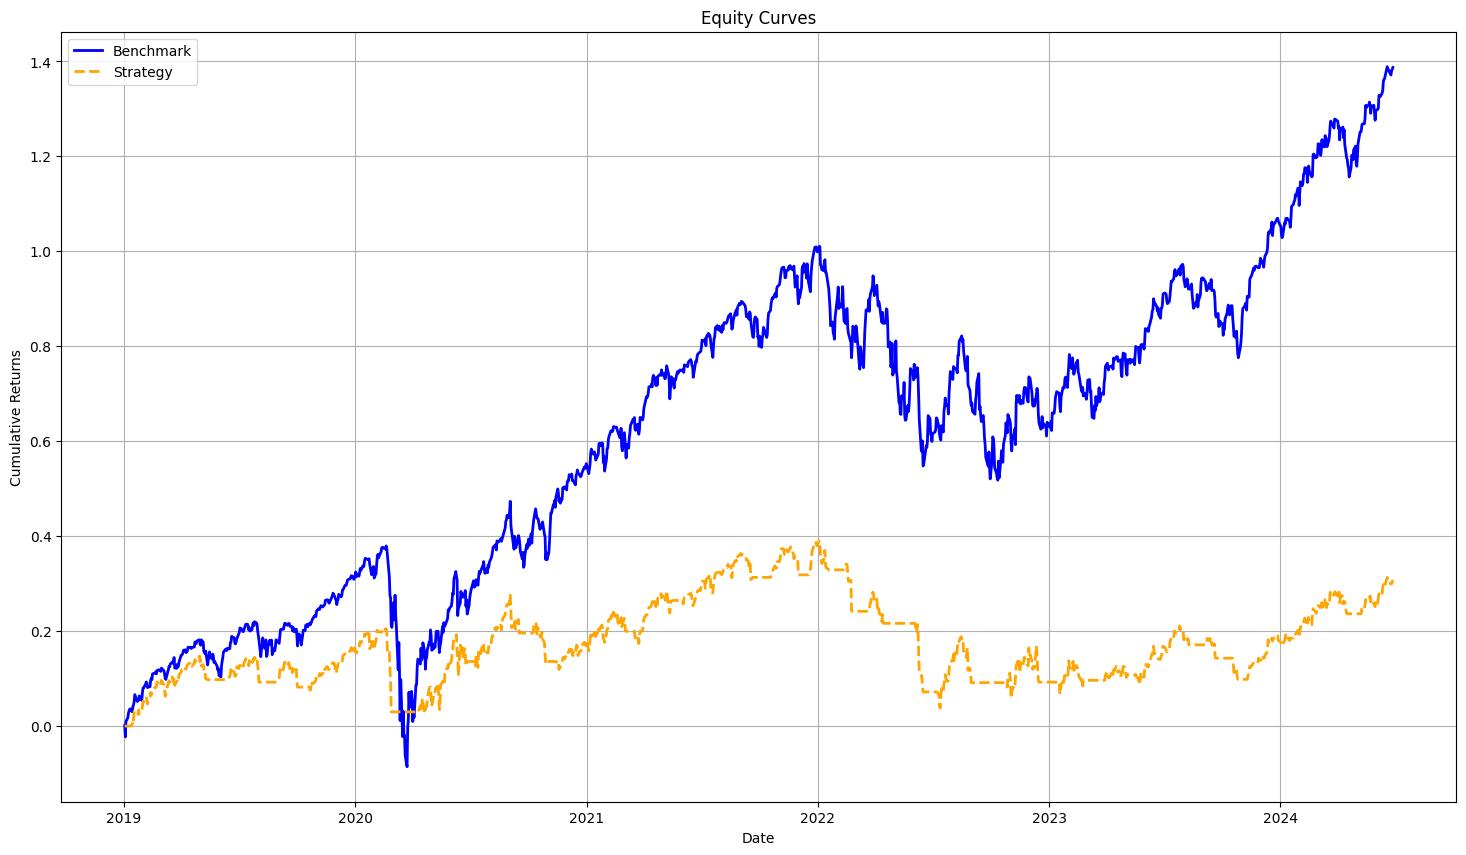

In [34]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Plot equity curves for both the benchmark and the strategy
plt.figure(figsize=(18, 10))

# Plot the benchmark cumulative returns
plt.plot(df_main['Date'], df_main['bench_prod_exp'], label='Benchmark', linestyle='solid', linewidth=2, color='blue')

# Plot the strategy cumulative returns
plt.plot(df_main['Date'], df_main['strat_prod_exp'], label='Strategy', linestyle='dashed', linewidth=2, color='orange')

# Add vertical lines for each year
years = mdates.YearLocator()  # every year
plt.gca().xaxis.set_major_locator(years)

# Add plot details
plt.legend()
plt.title('Equity Curves')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)

# Add vertical lines for each year
unique_years = pd.to_datetime(df_main['Date']).dt.year.unique()
for year in unique_years:
    plt.axvline(pd.Timestamp(f'{year}-01-01'), color='grey', linestyle='-', linewidth=1)

plt.show()


In [35]:
# Save Data
output_path = "/Users/okitrader/OneDrive/py_crypto_stock/data/HMM-SPY.csv"
df_main.write_csv(output_path)

print(f"Data saved to {output_path}")

Data saved to /Users/okitrader/OneDrive/py_crypto_stock/data/HMM-SPY.csv
